# Modelling

In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [16]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, RatingSVD, LogisticSVD
from RecData import RecData

## Data Preprocessing

In [17]:
# recs = pd.read_csv('data/recommendations.csv')
recs = pd.read_csv('data/pruned.csv')
# recs = pd.read_csv('data/2plus.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (1482532, 3)


,app_id,is_recommended,user_id
629351,12210,True,240
116928,22380,True,240
1418125,239140,True,240
236273,251570,True,240
87206,270880,True,240


In [18]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# # del recs

# start_time = time.time()
# print("Creating splits...")
# train_data, test = rec_data.train_test_split(test_size=0.2)
# print("First split done.")
# train_data, val = train_data.train_test_split(test_size=0.2)
# print("Done creating splits in", time.time() - start_time, "seconds")

In [19]:
random.seed(42)
np.random.seed(42)
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs
    
print("Creating splits...")
train_data, val, test = rec_data.leave_k_out_split(k=1)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
Done user 0
Done creating splits.


In [20]:
del rec_data
del item_data
del titles

## Ranker

This was used as a postprocessing step after using item-knn for candidate generation. Was not able to get good results.

In [21]:
# train = train_data.generate_dataframe()
# X_train = train[['app_id', 'user_id']]
# y_train = train['is_recommended'].to_numpy()

# X_train = X_train.sort_values(by='user_id')
# counts = X_train['user_id'].value_counts(sort=False)
# X_train = X_train[['app_id']]

In [22]:
# ranker = LGBMRanker(n_estimators=300, random_state=42, objective='lambdarank')
# ranker = ranker.fit(X_train, y_train, group = counts.values, categorical_feature=['app_id'],
#                     eval_set=[(X_train, y_train)], eval_group=[counts.values], 
#                     eval_at=20)

## Training SVD

Epoch 0/Training loss: 0.4798803319746788/Validation loss: 0.4757313974873899/Time: 7.54 seconds
Epoch 1/Training loss: 0.42781682816006184/Validation loss: 0.4253758855560578/Time: 5.44 seconds
Epoch 2/Training loss: 0.40613072947646356/Validation loss: 0.40496443212864525/Time: 5.49 seconds
Epoch 3/Training loss: 0.39400856060440537/Validation loss: 0.393796950416227/Time: 5.42 seconds
Epoch 4/Training loss: 0.38607730781989064/Validation loss: 0.3865598924903724/Time: 5.64 seconds
Epoch 5/Training loss: 0.38038606519289875/Validation loss: 0.38151952917596177/Time: 5.45 seconds
Epoch 6/Training loss: 0.3759893057228131/Validation loss: 0.37763439081709665/Time: 5.38 seconds
Epoch 7/Training loss: 0.3724808916406442/Validation loss: 0.37463253719648326/Time: 5.5 seconds
Epoch 8/Training loss: 0.36947860318956166/Validation loss: 0.3720488649569872/Time: 5.57 seconds
Epoch 9/Training loss: 0.3669528491963357/Validation loss: 0.36992246959999364/Time: 5.32 seconds


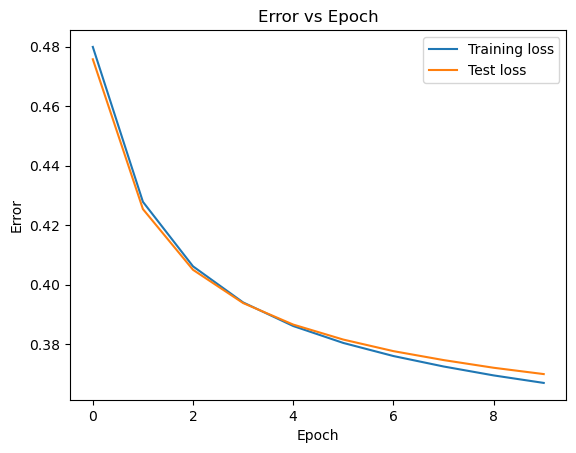

Validation rmse 0.36992246959999364


In [23]:
# for pruned, epoch: 30, lr:0.01, reg:0.02, k=50
# for pruned, epoch: 60, lr:0.01, reg:0.02, k=80

EPOCHS = 20

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = RatingSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=10, 
    learning_rate=0.001, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)
# svd_predictor = LogisticSVD(
#     train_data.get_num_users(), train_data.get_num_items(), 2, k=80, 
#     learning_rate=0.01, C=0.02)
# svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training loss')
plt.plot(range(len(val_errors)), val_errors, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Validation rmse", rmse)

We can now continue to train if we believe the model is still underfitting.

In [29]:
svd_predictor.continue_fit(10, early_stop=False)

Epoch 0/Training loss: 0.35074278817385124/Validation loss: 0.3566324704836711/Time: 5.47 seconds
Epoch 1/Training loss: 0.34983090398195676/Validation loss: 0.35588294633086287/Time: 6.28 seconds
Epoch 2/Training loss: 0.34895832620828626/Validation loss: 0.35517964962083753/Time: 5.95 seconds
Epoch 3/Training loss: 0.34811707623384347/Validation loss: 0.35451139382324853/Time: 5.72 seconds
Epoch 4/Training loss: 0.34732295683613384/Validation loss: 0.35391992942482825/Time: 5.44 seconds
Epoch 5/Training loss: 0.34656940429870897/Validation loss: 0.3533169450043422/Time: 5.36 seconds
Epoch 6/Training loss: 0.3458397707999454/Validation loss: 0.35274539437589286/Time: 5.43 seconds
Epoch 7/Training loss: 0.3451750574236804/Validation loss: 0.3522111724586196/Time: 5.52 seconds
Epoch 8/Training loss: 0.3445334372272865/Validation loss: 0.3517000058932951/Time: 5.55 seconds
Epoch 9/Training loss: 0.34392750088575885/Validation loss: 0.351227295571798/Time: 5.37 seconds


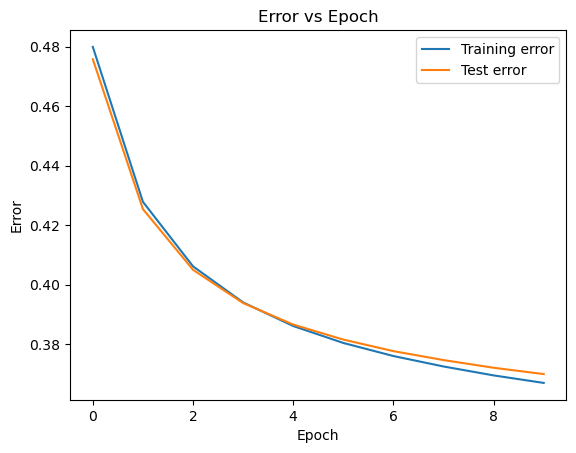

Test rmse 0.351227295571798


In [30]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

We compute similarities for item-knn.

In [9]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 0
Upto row 200
Upto row 400
Upto row 600
Upto row 800
Upto row 1000
Upto row 1200
Upto row 1400
Upto row 1600
Upto row 1800
Upto row 2000
Upto row 2200
Done computing similarities in 397.3743152618408 seconds


## Saving the model

In [11]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [2]:
with open('saved_models/2023-7-8-12-15-13_0-37.pkl', 'rb') as file:
    train_data, svd_predictor = pickle.load(file)

### Testing Rerank

In [10]:
# data.search_title('forza')

In [11]:
# filtered = svd_predictor.items_top_n([(286, 1)])
# app_ids = []
# for item_index in filtered:
#     app_ids.append(data.index_to_item_id(item_index))
# df = pd.DataFrame({'app_id': app_ids})
# predictions = ranker.predict(df)
# df['relevance'] = predictions
# df.head()
# df = df.sort_values(by='relevance', ascending=False)
# df.head()

In [12]:
# pprint([[data.index_to_title(data.item_id_to_index(i)) for _, i, _ in df.itertuples()]][0][:20])

### Testing Performance

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

In [11]:
train_data.search_title('call')

[('Call of Duty: World at War', 612),
 ("Forest Legends: The Call of Love Collector's Edition", 1377),
 ('Call of Duty® 4: Modern Warfare®', 530),
 ('Call of Duty®: Modern Warfare® 2 (2009)', 649),
 ('Call of Duty®: WWII', 867),
 ('theHunter: Call of the Wild™', 69),
 ('Call of Duty®: Black Ops III', 235),
 ('Call of Duty®: Black Ops', 517),
 ('S.T.A.L.K.E.R.: Call of Pripyat', 719),
 ('The Callisto Protocol™', 118),
 ('Call of Duty®: Infinite Warfare', 778),
 ('Call of Duty®: Black Ops II', 848),
 ('Call to Arms - Gates of Hell: Ostfront', 1085),
 ('Call to Arms', 1055),
 ('Call of Juarez: Gunslinger', 510),
 ('Call of Duty®: Modern Warfare® II', 28),
 ('Call of the Wild: The Angler™', 605),
 ('Call of Duty®: Modern Warfare® 3', 573),
 ('Call of Duty®: Advanced Warfare - Gold Edition', 1120)]

In [14]:
top = svd_predictor.items_knn([(573, 1)], n=1)
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.31919805788322353, 'Disney Princess: My Fairytale Adventure'),
 (0.31482037342062313, 'The Last Wizard'),
 (0.3146955018206333, 'RuneScape ®'),
 (0.30499141758494425, 'Get In The Car Loser!'),
 (0.3028254144699418, 'Kingdom Two Crowns'),
 (0.29852658924847986, 'PokerStars VR'),
 (0.2977899220999424, 'Sable'),
 (0.2946157731845478, 'Rust'),
 (0.29185394044662594, 'OVR Toolkit'),
 (0.288641998677187, 'Lil Gator Game')]


In [13]:
svd_predictor._user_features[0, :]
svd_predictor._item_features[1066, :]
np.max(svd_predictor._user_biases)
np.max(svd_predictor._item_biases)
# np.max(svd_predictor._item_features)

0.9472438167803995

In [32]:
j = 0

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 10)
print("Predicted top n:")
pprint([index for r, index in top_n])
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

OSError: [WinError -529697949] Windows Error 0xe06d7363

In [ ]:
# values, bins = np.histogram(svd_predictor._user_features[0, :])
# plt.stairs(values, bins)
# plt.show()

In [46]:
train_data.search_title('GunPoint')

[('Gunpoint', 1066)]

In [21]:
prefs = [(147, 1), (325, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(147, 'The Elder Scrolls V: Skyrim Special Edition', 1),
 (325, 'Slay the Spire', 1)]


In [22]:
epochs = 1

start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=epochs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Time: 6.88 seconds
Completed partial fit in 7.875029563903809 seconds


In [28]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 10)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.9987608146858127, 'Portal 2'),
 (0.9969967969293526, 'A Hat in Time'),
 (0.9952055750129399, 'Terraria'),
 (0.9939231456186107, 'Thief™ II: The Metal Age'),
 (0.9938464256065681, 'Lil Gator Game'),
 (0.9936272229187082, 'Mafia II (Classic)'),
 (0.9934598331074666, 'POSTAL 2'),
 (0.9909451404418662, 'Monolith'),
 (0.9907963903985133, 'Choice of Robots'),
 (0.9907266718244505, 'Bastion')]
